In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import os
os.listdir("/kaggle/input/")


['crack-segmentation-dataset']

In [3]:
image_path = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images/"
mask_path = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks/"

In [4]:
def load_images(image_folder, mask_folder, img_size=(128, 128)):
    images, masks = [], []
    
    for img_name in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, img_size) / 255.0     # Normalize

        mask = cv2.imread(os.path.join(mask_folder, img_name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0   # Normalize
        mask = np.expand_dims(mask, axis=-1)       # Add channel dimension

        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_images(image_path, mask_path)

# Split into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training images: {X_train.shape}, Validation images: {X_val.shape}")

Training images: (9038, 128, 128, 3), Validation images: (2260, 128, 128, 3)


In [5]:
def attention_gate(x, g, filters):
    g_conv = layers.Conv2D(filters, (1, 1), padding="same")(g)
    x_conv = layers.Conv2D(filters, (1, 1), padding="same")(x)
    add = layers.Add()([g_conv, x_conv])
    add = layers.Activation("relu")(add)
    
    attention = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(add)
    return layers.Multiply()([x, attention])

In [6]:
def unet_with_attention(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder with Attention
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    ag1 = attention_gate(c4, u6, 512)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(ag1)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    ag2 = attention_gate(c3, u7, 256)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(ag2)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    ag3 = attention_gate(c2, u8, 128)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(ag3)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    ag4 = attention_gate(c1, u9, 64)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(ag4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return models.Model(inputs, outputs)

In [11]:
model = unet_with_attention((128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 64)     │              0 │ conv2d_55[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 32, 32, 128)    │              0 │ conv2d_57[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 16, 16, 256)    │              0 │ conv2d_59[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_60[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 8, 8, 512)      │              0 │ conv2d_61[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_62[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_63[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)   

 Total params: 25,463,109 (97.13 MB)

 Trainable params: 25,463,109 (97.13 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.fit(X_train, Y_train, batch_size=8, epochs=20, validation_data=(X_val, Y_val))

Epoch 1/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 161s 124ms/step - accuracy: 0.9445 - loss: 0.1494 - val_accuracy: 0.9522 - val_loss: 0.1252
Epoch 2/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 120s 106ms/step - accuracy: 0.9523 - loss: 0.1185 - val_accuracy: 0.9534 - val_loss: 0.1099
Epoch 3/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 120s 106ms/step - accuracy: 0.9533 - loss: 0.1115 - val_accuracy: 0.9538 - val_loss: 0.1085
Epoch 4/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 120s 106ms/step - accuracy: 0.9533 - loss: 0.1085 - val_accuracy: 0.9542 - val_loss: 0.1142
Epoch 5/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 120s 106ms/step - accuracy: 0.9538 - loss: 0.1042 - val_accuracy: 0.9550 - val_loss: 0.0939
Epoch 6/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 120s 106ms/step - accuracy: 0.9548 - loss: 0.0947 - val_accuracy: 0.9563 - val_loss: 0.0889
Epoch 7/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 120s 106ms/step - accuracy: 0.9558 - loss: 0.0875 - val_accuracy: 0.9575 - val_loss: 0.0816
Epoch 8/20
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 120s 106ms/step - ac

In [18]:
def visualize_predictions(X_test, Y_test, model, num_samples=5):
    predictions = model.predict(X_test)

    plt.figure(figsize=(10, num_samples * 3))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X_test[i])
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(Y_test[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step


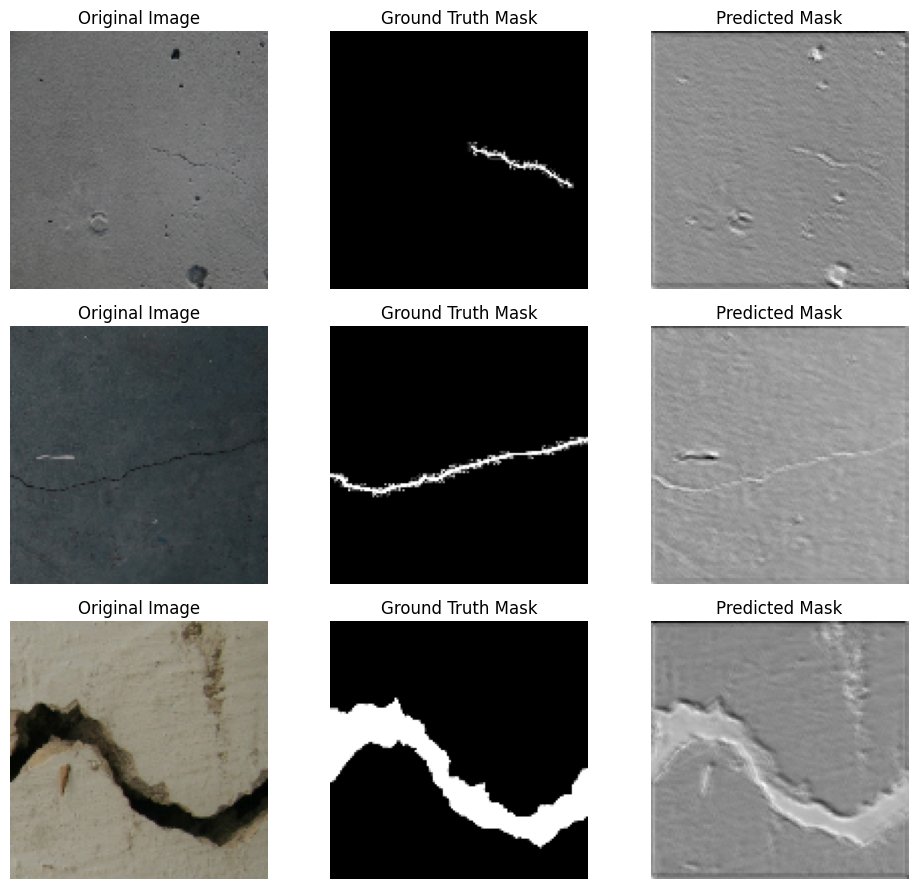

In [21]:
visualize_predictions(X_val, Y_val, model, num_samples=3)